# Wildlife Binary Classification with ResNet

This notebook trains a ResNet model to classify images as either containing wildlife (label 1) or being empty (label 0).

## Dataset Structure
- Images are stored in the `dataset/` folder
- Labels are stored in `labels.json` (0 = empty, 1 = wildlife)

In [1]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms, models
from torchvision.models import ResNet18_Weights
import json
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
from pathlib import Path
import random
from tqdm.auto import tqdm

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"Torchvision version: {torchvision.__version__}")

Libraries imported successfully!
PyTorch version: 2.8.0+cu128
Torchvision version: 0.23.0+cu128


In [2]:
# Check device availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("CUDA not available, using CPU")

Using device: cpu
CUDA not available, using CPU


In [3]:
# Load labels and check data
with open('labels.json', 'r') as f:
    labels_dict = json.load(f)

# Print dataset statistics
total_images = len(labels_dict)
wildlife_count = sum(1 for label in labels_dict.values() if label == 1)
empty_count = sum(1 for label in labels_dict.values() if label == 0)

print(f"Dataset Statistics:")
print(f"Total images: {total_images}")
print(f"Wildlife images (label 1): {wildlife_count} ({wildlife_count/total_images*100:.1f}%)")
print(f"Empty images (label 0): {empty_count} ({empty_count/total_images*100:.1f}%)")

# Check if images exist in dataset folder
dataset_path = Path('dataset')
existing_images = []
missing_images = []

for image_name in labels_dict.keys():
    image_path = dataset_path / image_name
    if image_path.exists():
        existing_images.append(image_name)
    else:
        missing_images.append(image_name)

print(f"\nImage availability:")
print(f"Images found: {len(existing_images)}")
print(f"Images missing: {len(missing_images)}")

if missing_images:
    print(f"First few missing images: {missing_images[:5]}")

Dataset Statistics:
Total images: 32813
Wildlife images (label 1): 14359 (43.8%)
Empty images (label 0): 18454 (56.2%)

Image availability:
Images found: 32813
Images missing: 0


In [4]:
# Custom Dataset Class
class WildlifeDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Data transformations
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Dataset class and transformations defined!")

Dataset class and transformations defined!


In [5]:
# Prepare data for training (only images starting with 'T')
image_paths = []
labels = []

for image_name in existing_images:
    if image_name.startswith('T'):  # Only use images whose name starts with 'T'
        image_path = dataset_path / image_name
        image_paths.append(str(image_path))
        labels.append(labels_dict[image_name])

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Print summary
print(f"Total labeled images found: {len(existing_images)}")
print(f"Images starting with 'T' used for training/testing: {len(image_paths)}")
print(f"Images excluded (for inference only): {len(existing_images) - len(image_paths)}")

# Create dataset
full_dataset = WildlifeDataset(image_paths, labels, transform=transform_train)

# Split dataset (80% train, 20% validation)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size

train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Update validation dataset to use validation transforms
val_indices = val_dataset.indices
val_paths = image_paths[val_indices]
val_labels = labels[val_indices]
val_dataset = WildlifeDataset(val_paths, val_labels, transform=transform_val)

print(f"Train set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print(f"Data loaders created with batch size: {batch_size}")


Total labeled images found: 32813
Images starting with 'T' used for training/testing: 10412
Images excluded (for inference only): 22401
Train set size: 8329
Validation set size: 2083
Data loaders created with batch size: 32


In [6]:
# Load pre-trained ResNet model
model = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

# Freeze early layers (optional - for fine-tuning)
for param in model.parameters():
    param.requires_grad = False

# Modify the final layer for binary classification
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # 2 classes: empty (0) and wildlife (1)

# Unfreeze the final layer
for param in model.fc.parameters():
    param.requires_grad = True

# Move model to device
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print(f"Model architecture:")
print(f"ResNet18 with modified final layer")
print(f"Input features to FC layer: {num_ftrs}")
print(f"Output classes: 2")
print(f"Model moved to: {device}")

Model architecture:
ResNet18 with modified final layer
Input features to FC layer: 512
Output classes: 2
Model moved to: cpu


In [7]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        
        for images, labels in train_pbar:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100 * correct_predictions / total_predictions:.2f}%'
            })
        s
        train_loss = running_loss / len(train_loader)
        train_acc = correct_predictions / total_predictions
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            val_pbar = tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]')
            
            for images, labels in val_pbar:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                
                # Update progress bar
                val_pbar.set_postfix({
                    'Loss': f'{loss.item():.4f}',
                    'Acc': f'{100 * val_correct / val_total:.2f}%'
                })
        
        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
        print('-' * 50)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_wildlife_model.pth')
            print(f'New best model saved with validation accuracy: {best_val_acc:.4f}')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

print("Training function defined!")

Training function defined!


In [8]:
# Train the model
print("Starting training...")
num_epochs = 35

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs
)

print("Training completed!")

Starting training...


Epoch 1/35 [Train]:   0%|          | 0/261 [00:00<?, ?it/s]

KeyboardInterrupt: 

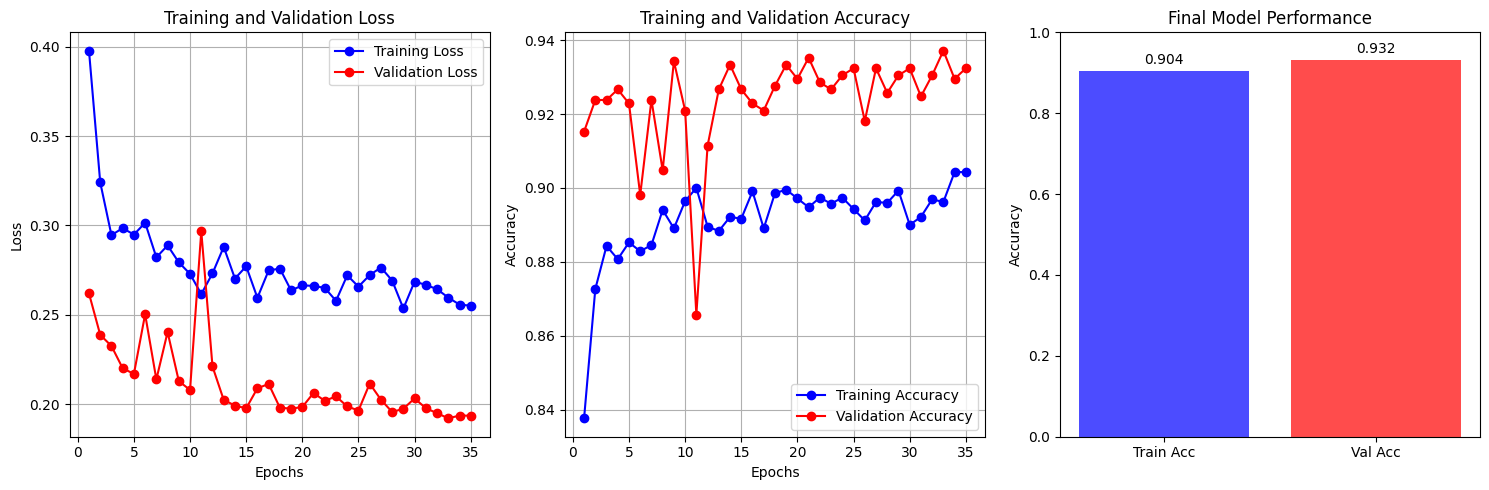

Final Training Accuracy: 0.9043
Final Validation Accuracy: 0.9324


In [ ]:
# Plot training history
plt.figure(figsize=(15, 5))

# Plot losses
plt.subplot(1, 3, 1)
plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo-', label='Training Loss')
plt.plot(range(1, len(val_losses) + 1), val_losses, 'ro-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Plot accuracies
plt.subplot(1, 3, 2)
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, 'bo-', label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, 'ro-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

# Plot final metrics
plt.subplot(1, 3, 3)
final_metrics = ['Train Acc', 'Val Acc']
final_values = [train_accuracies[-1], val_accuracies[-1]]
bars = plt.bar(final_metrics, final_values, color=['blue', 'red'], alpha=0.7)
plt.ylabel('Accuracy')
plt.title('Final Model Performance')
plt.ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, final_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{value:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Validation Accuracy: {val_accuracies[-1]:.4f}")

Evaluating:   0%|          | 0/33 [00:00<?, ?it/s]

=== Model Evaluation Results ===
Accuracy:  0.9371
Precision: 0.9362
Recall:    0.9692
F1-Score:  0.9524


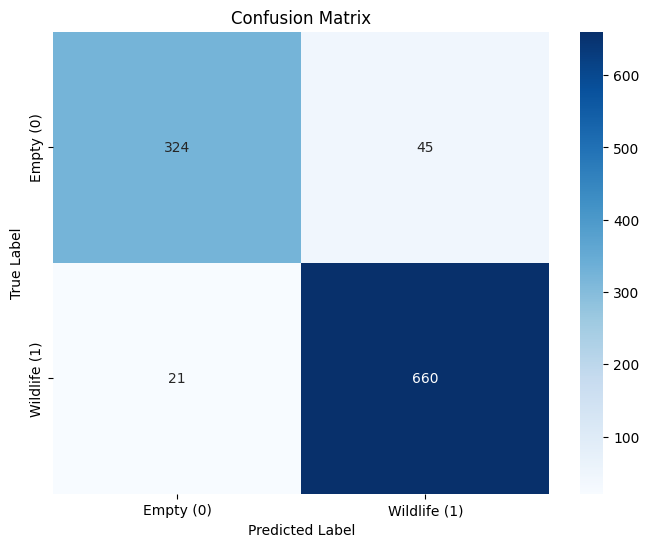


Confusion Matrix:
True Negatives (Empty → Empty): 324
False Positives (Empty → Wildlife): 45
False Negatives (Wildlife → Empty): 21
True Positives (Wildlife → Wildlife): 660


In [ ]:
# Evaluate model on validation set
def evaluate_model(model, val_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(val_loader, desc="Evaluating"):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Load best model and evaluate
model.load_state_dict(torch.load('best_wildlife_model.pth'))
predictions, true_labels = evaluate_model(model, val_loader, device)

# Calculate metrics
accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print("=== Model Evaluation Results ===")
print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Empty (0)', 'Wildlife (1)'],
            yticklabels=['Empty (0)', 'Wildlife (1)'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

print(f"\nConfusion Matrix:")
print(f"True Negatives (Empty → Empty): {cm[0,0]}")
print(f"False Positives (Empty → Wildlife): {cm[0,1]}")
print(f"False Negatives (Wildlife → Empty): {cm[1,0]}")
print(f"True Positives (Wildlife → Wildlife): {cm[1,1]}")

Sample Prediction:
Image: T12RCNX0235.JPG
Predicted Class: Wildlife
Confidence: 0.9989
Probabilities: Empty=0.0011, Wildlife=0.9989


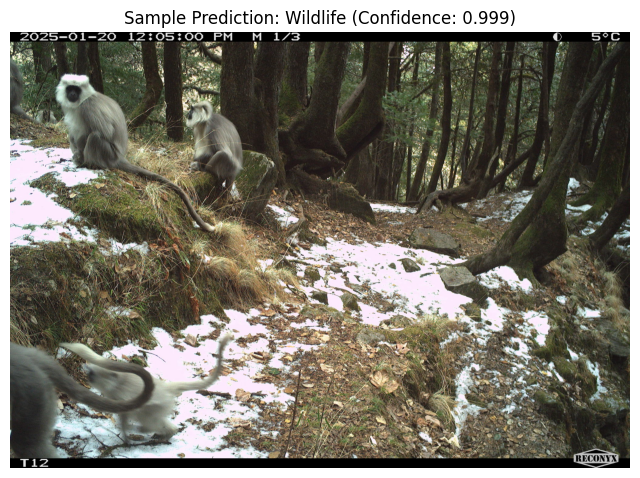

In [ ]:
# Function to predict on a single image
def predict_single_image(model, image_path, transform, device, class_names=['Empty', 'Wildlife']):
    """
    Predict the class of a single image
    
    Args:
        model: Trained PyTorch model
        image_path: Path to the image file
        transform: Image preprocessing transforms
        device: Device to run inference on
        class_names: List of class names
    
    Returns:
        predicted_class, confidence, probabilities
    """
    model.eval()
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
        
        predicted_class = predicted_class.item()
        confidence = confidence.item()
        probabilities = probabilities.squeeze().cpu().numpy()
    
    return predicted_class, confidence, probabilities

# Test the prediction function with a sample image
sample_image_path = val_paths[0]  # Use first validation image
predicted_class, confidence, probabilities = predict_single_image(
    model, sample_image_path, transform_val, device
)

class_names = ['Empty', 'Wildlife']
print(f"Sample Prediction:")
print(f"Image: {Path(sample_image_path).name}")
print(f"Predicted Class: {class_names[predicted_class]}")
print(f"Confidence: {confidence:.4f}")
print(f"Probabilities: Empty={probabilities[0]:.4f}, Wildlife={probabilities[1]:.4f}")

# Display the sample image
plt.figure(figsize=(8, 6))
sample_image = Image.open(sample_image_path)
plt.imshow(sample_image)
plt.title(f"Sample Prediction: {class_names[predicted_class]} (Confidence: {confidence:.3f})")
plt.axis('off')
plt.show()

## Using the Trained Model

### Command Line Interface

To use the trained model on a specific image, create and use the following command line script:

In [ ]:
# Create a command-line script for model inference
inference_script = '''#!/usr/bin/env python3
"""
Wildlife Classification Inference Script
Usage: python predict_image.py <image_path>
"""

import torch
import torch.nn as nn
from torchvision import transforms, models
from PIL import Image
import sys
from pathlib import Path

def load_model(model_path, device):
    """Load the trained model"""
    model = models.resnet18(pretrained=False)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 2)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def predict_image(image_path, model, device):
    """Predict wildlife presence in an image"""
    # Image preprocessing
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Load and preprocess image
    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)
    
    # Make prediction
    with torch.no_grad():
        outputs = model(image_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted_class = torch.max(probabilities, 1)
        
        predicted_class = predicted_class.item()
        confidence = confidence.item()
        probabilities = probabilities.squeeze().cpu().numpy()
    
    return predicted_class, confidence, probabilities

def main():
    if len(sys.argv) != 2:
        print("Usage: python predict_image.py <image_path>")
        sys.exit(1)
    
    image_path = sys.argv[1]
    
    if not Path(image_path).exists():
        print(f"Error: Image file '{image_path}' not found")
        sys.exit(1)
    
    # Setup
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_path = 'best_wildlife_model.pth'
    
    if not Path(model_path).exists():
        print(f"Error: Model file '{model_path}' not found")
        print("Please make sure you have trained the model first")
        sys.exit(1)
    
    # Load model and predict
    model = load_model(model_path, device)
    predicted_class, confidence, probabilities = predict_image(image_path, model, device)
    
    class_names = ['Empty', 'Wildlife']
    
    print(f"\\n=== Wildlife Classification Result ===")
    print(f"Image: {Path(image_path).name}")
    print(f"Predicted Class: {class_names[predicted_class]}")
    print(f"Confidence: {confidence:.4f}")
    print(f"Probabilities:")
    print(f"  Empty: {probabilities[0]:.4f}")
    print(f"  Wildlife: {probabilities[1]:.4f}")
    print("=" * 40)

if __name__ == "__main__":
    main()
'''

# Save the inference script
with open('predict_image.py', 'w') as f:
    f.write(inference_script)

print("Inference script 'predict_image.py' created successfully!")
print("\\nUsage:")
print("python predict_image.py <path_to_image>")
print("\\nExample:")
print("python predict_image.py dataset/T13RCNX0001.JPG")

Inference script 'predict_image.py' created successfully!
\nUsage:
python predict_image.py <path_to_image>
\nExample:
python predict_image.py dataset/T13RCNX0001.JPG


## Summary

This notebook provides a complete pipeline for wildlife binary classification:

1. **Data Loading**: Loads images from the `dataset/` folder and labels from `labels.json`
2. **Data Preprocessing**: Applies appropriate transforms for training and validation
3. **Model Architecture**: Uses ResNet18 with transfer learning, fine-tuning only the final layer
4. **Training**: Trains the model with data augmentation and saves the best model
5. **Evaluation**: Provides comprehensive metrics including accuracy, precision, recall, and F1-score
6. **Inference**: Creates a command-line script for predicting on new images

### Key Files Generated:
- `best_wildlife_model.pth`: The trained model weights
- `predict_image.py`: Command-line inference script

### Command Line Usage:
```bash
python predict_image.py path/to/your/image.jpg
```

The model classifies images as either:
- **Empty (0)**: No wildlife detected
- **Wildlife (1)**: Wildlife detected